# Homework 3 CSCI 4364/6364 Machine Learning

##**A Tour of Multivariate Classification**

**Due Date: 10/3/2024, 23:59 ET**

---

**Purpose:**
This homework will provide you with hands-on experience with some of the multivariate classification algorithms we discussed in class and expose you to one of the most cited datasets, MNIST.

You should get a broad appreciation for the various approaches to classification that will help you evaluate which approach is best for your real world research or industry application.

The [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. MNIST is a good dataset for this assignment, since it has 10 classes (0 - 9) with a large number of features.


---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks.

> **Important:** Please save and submit your homework assignment notebook with outputs. You can do this by selecting `Edit` >> `Notebook settings` and making sure the option `Omit code cell output when saving this notebook` is **NOT** selected.

**Grading on the notebook:**
This notebook is worth up to 5% (with up to 3% additional extra credit) of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Coding Standards:**
Throughout this course, we will use [Google’s Python Style Guide](https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** Vidhi Khandelwal

**GW ID:** G30891152

In [2]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################
from sklearn.datasets import fetch_openml
from keras.utils import to_categorical
import numpy as np
import time
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import matplotlib.image as mpimg
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from typing import Dict, Optional
import tensorflow as tf
from gc import callbacks
from tensorflow import keras
from tensorflow.keras import layers


First, download the MNIST data using the code provided below.

Here are the first 9 digits of the MNIST data with label.


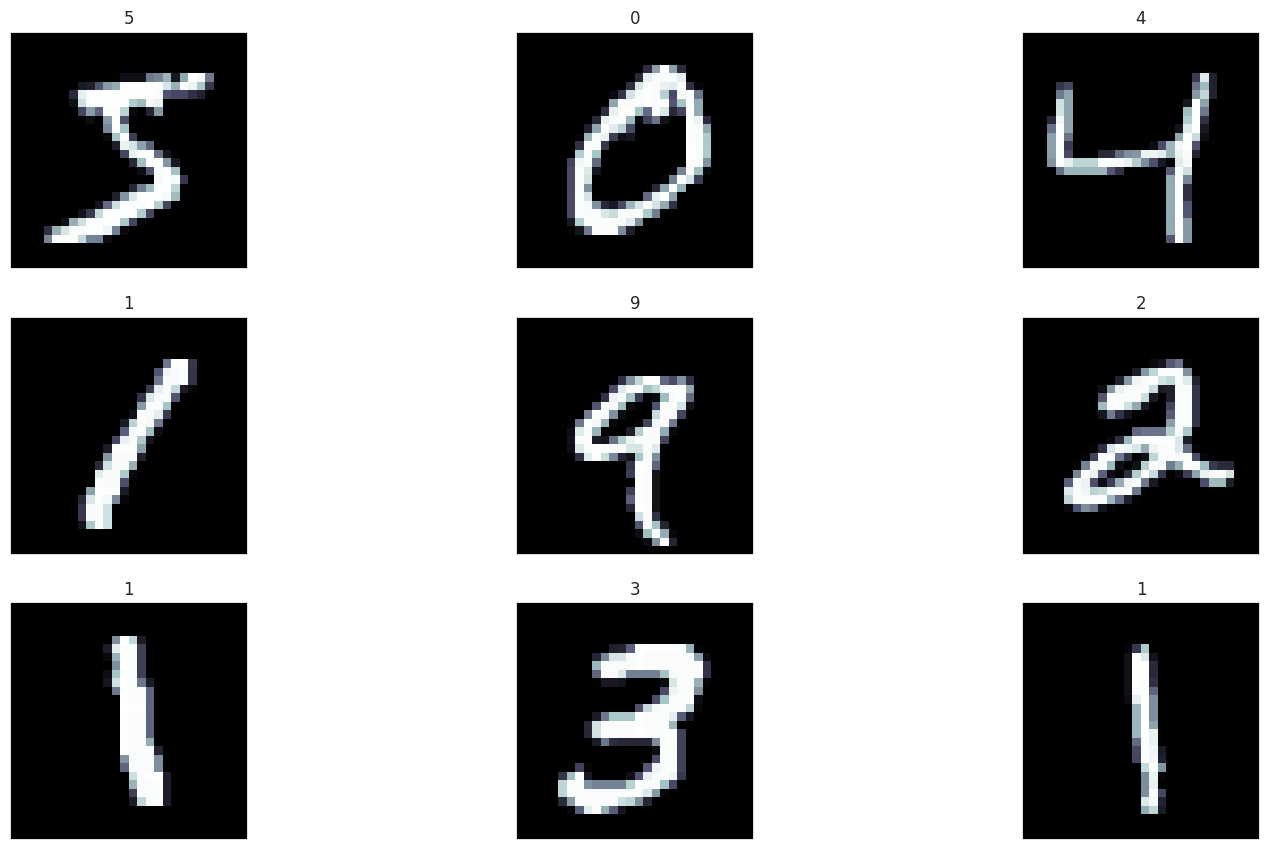

In [3]:
#@title Download MNIST, split, and plot example
def plot_example(x_raw, y_raw):
  fig, axes = plt.subplots(3, 3)
  i = 0
  for i in range(3):
    for j in range(3):
      imgplot = axes[i,j].imshow(x_raw[i*3 + j].reshape((28,28)), cmap = 'bone')
      axes[i,j].set_title(y_raw[i*3 + j])
      axes[i,j].get_yaxis().set_visible(False)
      axes[i,j].get_xaxis().set_visible(False)
  fig.set_size_inches(18.5, 10.5, forward=True)


x_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x_raw/255).astype('float32').to_numpy()

# Split the data set into train, validation, and test sets.
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y_raw, test_size=0.10, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.10, random_state=42)
print('Here are the first 9 digits of the MNIST data with label.')
plot_example(x, y_raw)

As in the past assignments, we'll define our base learning algorithm class, and create multiple implementations. Here, in the fit (or train) method, along with x_train and y_train, we'll include x_val, and y_val, as validation sets. Not all implementations will use them.

In [4]:
#@title Define a base class class for Learning Algorithm

class BaseLearningAlgorithm(ABC):
  """Base class for a Supervised Learning Algorithm."""

  @abstractmethod
  def fit(self, x_train:np.array, y_train: np.array
          , x_val:np.array
          , y_val:np.array) -> None:
    """Trains a model from labels y and examples X.
    We include validation set for optional hyperparameter tuning. Not
    all of the algorithims we use will
    """

  @abstractmethod
  def predict(self, x_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X."""

  @property
  @abstractmethod
  def name(self) -> str:
    """Returns the name of the algorithm."""

Next, we want to establish a common approach to evaluating our implementations of `BaseLearningAlgorithm`.

A **Confusion Matrix** is a data table that helps visualize the performance of a multi-class classifier. The rows represent the true class assignmants from the test set labels, and the columns represent the predicted classes generated by the classifier. A perfect classifier will only populate the diagonal with counts and all off-diagonal elements of the matrix will be zero. Off-diagonal counts indiate that the model confuses the class in row $i$ with the class in column $j$. For example, in MNIST, the number $9$ might be confused $4$, and the associated cell at $i, j$ will be greater than $0$.

Besides precision and accuracy, the **F1-Score** is often used.  Review this [Wikipedia article](https://en.wikipedia.org/wiki/F-score) on F-Score.

##Question 1.
The Wikipedia article indicates that one weakness of the F-Score is that it assigns equal importance to precision and recall. Describe two scenarios where (a) precision may be more important to recall, and (b) where recall may be more important than precision.

**Answer**: The F-score assigns equal weight to precision and recall, but in certain real-world scenarios, one may be more critical than the other. Precision is more important than recall when the cost of false positives is high. For instance, in spam detection, a high precision ensures legitimate emails are not incorrectly marked as spam, preventing important messages from being lost. Similarly, in medical diagnosis for severe conditions, high precision minimizes unnecessary anxiety or costly follow-up tests by reducing false positives. In such cases, letting a few positive instances go undetected (lower recall) is preferable to the negative consequences of falsely identifying normal instances as positive.

On the other hand, recall becomes more important when the cost of false negatives is high, meaning missing positive cases is riskier. In cancer screening, for example, high recall ensures most cancer cases are detected, even if it results in a few healthy individuals being flagged, as missing a cancer diagnosis can have life-threatening consequences. Similarly, in search and rescue missions, high recall ensures potential survivors are not overlooked, even if it means inspecting a few false alarms. Thus, recall is prioritized over precision when it is crucial not to miss any positive cases, despite the possibility of increased false positives.

In [5]:
#@title Define a basic train and evaluation pipeline

def train_eval(learning_algo: BaseLearningAlgorithm, x_train, y_train,x_val, y_val, x_test, y_test):
  """Trains and evaluates the generic model."""
  learning_algo.fit(x_train, y_train, x_val, y_val)
  y_pred = learning_algo.predict(x_test)
  mat = confusion_matrix(y_test, y_pred)
  sns.set(rc = {'figure.figsize':(8,8)})
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(10)],
              yticklabels=['%d' %i for i in range(10)])
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.title(learning_algo.name)

  print(classification_report(y_test, y_pred,
                              target_names=['%d' %i for i in range(10)]))




#1. Linear model with Logistic Regression
Let's start with basic logistic regression and demonstrate that Logistic Regression works on a multiclass classification problem.

We'll use the familiar least squares regression model with L2 regularization as a baseline for comparison.

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       683
           1       0.94      0.97      0.96       800
           2       0.90      0.89      0.90       674
           3       0.89      0.89      0.89       760
           4       0.92      0.93      0.93       611
           5       0.90      0.88      0.89       658
           6       0.94      0.95      0.94       677
           7       0.93      0.94      0.93       724
           8       0.90      0.86      0.88       693
           9       0.92      0.90      0.91       720

    accuracy                           0.92      7000
   macro avg       0.92      0.92      0.92      7000
weighted avg       0.92      0.92      0.92      7000

CPU times: user 2min, sys: 11.8 s, total: 2min 12s
Wall time: 1min 19s


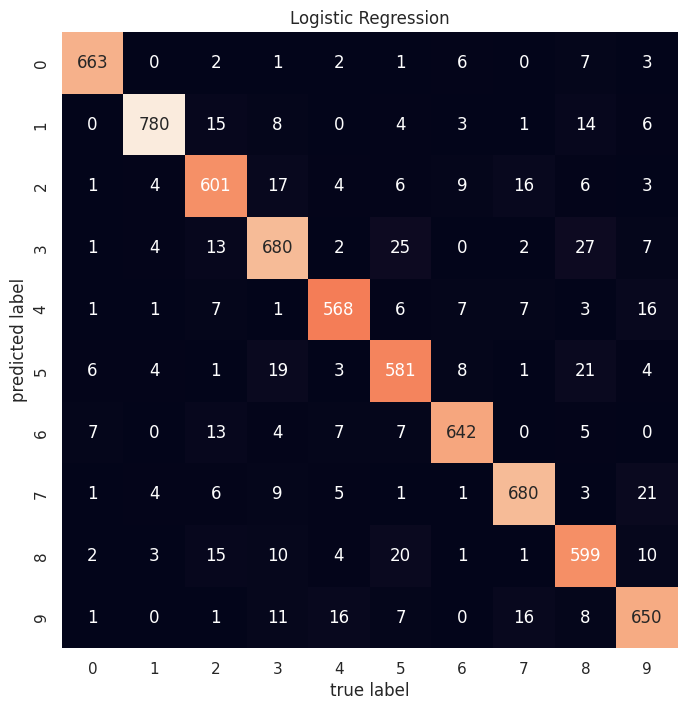

In [6]:
#@title Define the basic Logistic Regression Model

class LogisticRegressionLearningAlgorithm(BaseLearningAlgorithm):
  """Minimalist wrapper class for basic Logistic Regression."""

  def __init__(self, max_iters: int = 1000):
    self._model = LogisticRegression(max_iter = max_iters, verbose = True, penalty = 'l2')

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    self._model.fit(x_train,y_train)
    # Don't need the validation data in Logistic Regression

  def predict(self, x_test: np.array) -> np.array:
    return self._model.predict(x_test)

  @property
  def name(self) -> str:
    return 'Logistic Regression'

learning_algo = LogisticRegressionLearningAlgorithm(max_iters = 1000)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

#2. Support Vector Machine + Principal Components Analysis
In this section, we'll investigate the Support Vector Machine with and without dimensionality reduction using PCA.

##2.1 Basic SVM (Task 1)
In the block below, use Scikit-Learn's SVM classifier, SVC. Configure the SVC with a Radial Basis Function Kernel (RBF), and parameterize the cost value and the RBF gamma parameter.

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.94      0.98      0.96       800
           2       0.92      0.92      0.92       674
           3       0.91      0.90      0.90       760
           4       0.89      0.94      0.92       611
           5       0.90      0.90      0.90       658
           6       0.95      0.96      0.96       677
           7       0.95      0.94      0.95       724
           8       0.94      0.88      0.91       693
           9       0.93      0.91      0.92       720

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000

CPU times: user 10min, sys: 746 ms, total: 10min
Wall time: 10min 4s


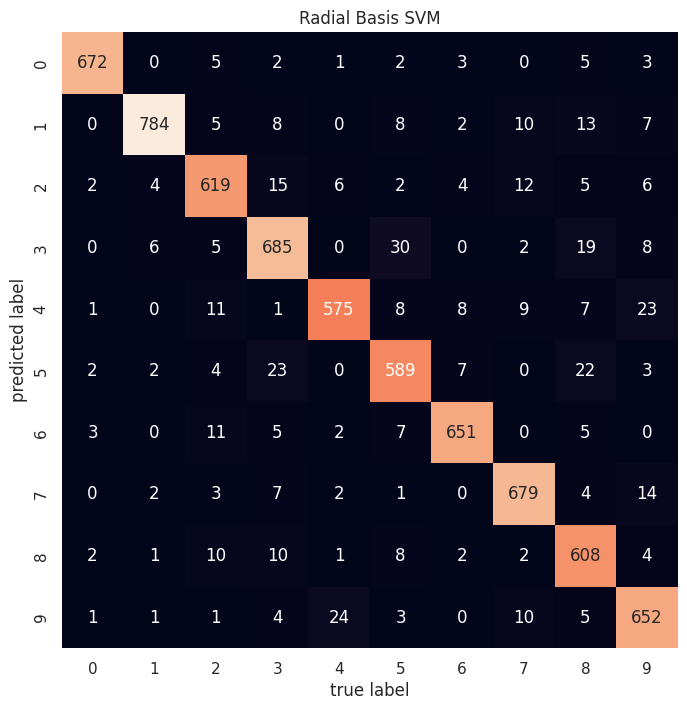

In [7]:


class RadialBasisSvmLearningAlgorithm(BaseLearningAlgorithm):
    """RBF SVM Classifier function."""

    def __init__(self, cost: float, gamma: float):
        # Initialize the SVM classifier with RBF kernel and specified parameters
        self._model = SVC(C=cost, kernel='rbf', gamma=gamma)

    def fit(self, x_train: np.array, y_train: np.array, x_val: np.array, y_val: np.array) -> None:
        # Train the model on the training data
        self._model.fit(x_train, y_train)
        # Validation data is passed

    def predict(self, x_test: np.array) -> np.array:
        # Predict the labels for the test data
        return self._model.predict(x_test)

    @property
    def name(self) -> str:
        # Return the name of the model for display purposes
        return 'Radial Basis SVM'

# Initialize the RadialBasisSvmLearningAlgorithm with the cost and gamma parameters
learning_algo = RadialBasisSvmLearningAlgorithm(cost=10.0, gamma=0.0001)

# Train and evaluate the model using the train_eval function
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)


##2.2 Dimensionality Reduction with PCA (Task 2)

Next, we'll use PCA to reduce the input space from 784 dimensions to lower dimensions with lower variance. But how how many dimensions do we choose to keep? To help deceide that, we should first plot out the explained varaince by the number of singular values. This gives us picture of how much information is lost by removing the smallest singular values.  

In the code below, use Scikit-Learn's PCA class with `x_train` and plot out the explained variance ratio against the number of components (singular values).  

In [ ]:
#@title Fit PCA and plot the explained variance as a function of components

print("please implement me")

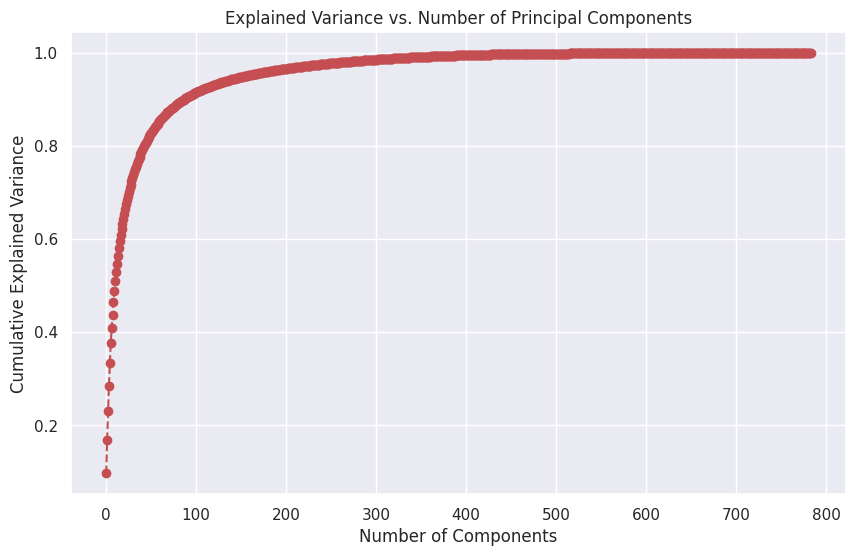

In [9]:


# Step 1: Fit PCA on the training data
pca = PCA()
pca.fit(x_train)  # Fit PCA to the training data to compute principal components

# Step 2: Plot the explained variance ratio
explained_variance = pca.explained_variance_ratio_  # Array of explained variance ratios

# Step 3: Create a cumulative variance plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--', color='r')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')

plt.show()


In [11]:
# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# To Find the number of components for 80% and 90% variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1  # Adding 1 because np.argmax returns 0-based index
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"Number of components to represent 80% of explained variance: {n_components_80}")
print(f"Number of components to represent 90% of explained variance: {n_components_90}")


Number of components to represent 80% of explained variance: 43
Number of components to represent 90% of explained variance: 87


##Question 2.
Based on the variance vs. num components chart above, how many components represent 80% and 90% of the explained variance?

**Answer**:
1. Number of components to represent 80% of explained variance: 43
2. Number of components to represent 90% of explained variance: 87

##2.2 Apply PCA to reduce dimensionality for SVM (Task 3)

In the code block below, extend the basic SVM class from 2.1 and name it `RadialBasisSvmPcaLearningAlgorithm` that first reduces the dimension. You can use Scikit-Learn's `make_pipeline()` method to combine PCA and SVC into a pipeline.

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       683
           1       0.92      0.98      0.95       800
           2       0.90      0.89      0.90       674
           3       0.89      0.86      0.87       760
           4       0.89      0.93      0.91       611
           5       0.87      0.88      0.87       658
           6       0.93      0.95      0.94       677
           7       0.94      0.93      0.93       724
           8       0.91      0.84      0.87       693
           9       0.91      0.88      0.89       720

    accuracy                           0.91      7000
   macro avg       0.91      0.91      0.91      7000
weighted avg       0.91      0.91      0.91      7000

CPU times: user 1min 23s, sys: 493 ms, total: 1min 23s
Wall time: 1min 25s


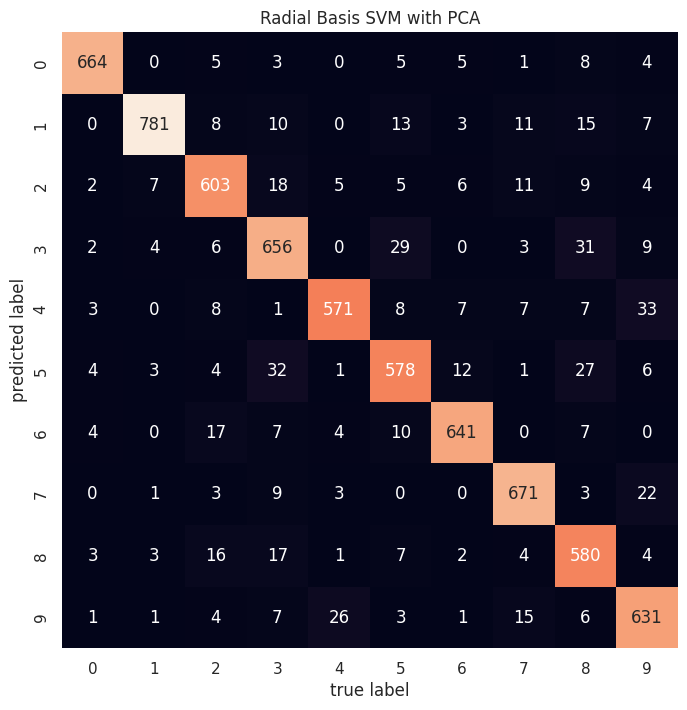

In [12]:

class RadialBasisSvmPcaLearningAlgorithm(BaseLearningAlgorithm):
    """SVM Classifier with PCA dimensionality reduction."""

    def __init__(self, num_pca_components: int, cost: float, gamma: float):
        # Create a pipeline that applies PCA followed by the SVM classifier
        self._model = make_pipeline(
            PCA(n_components=num_pca_components),  # PCA with the specified number of components
            SVC(C=cost, gamma=gamma, kernel='rbf')  # SVM with RBF kernel
        )

    def fit(self, x_train: np.array, y_train: np.array, x_val: np.array, y_val: np.array) -> None:
        # Fit the pipeline model (PCA + SVM)
        self._model.fit(x_train, y_train)
        # We are not using validation data for fitting

    def predict(self, x_test: np.array) -> np.array:
        # Predict using the trained pipeline model
        return self._model.predict(x_test)

    @property
    def name(self) -> str:
        return 'Radial Basis SVM with PCA'

# Instantiate the RadialBasisSvmPcaLearningAlgorithm with PCA and SVM parameters
learning_algo = RadialBasisSvmPcaLearningAlgorithm(num_pca_components=30, cost=10.0, gamma=0.0001)

# Evaluate the model using the train_eval function
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)


##Question 3.
What is the minimum number of components required to achieve equivalent performance to basic SVM without PCA (2.1)?

**Answer**: Approximately 150-200 components would be sufficient to achieve an accuracy of around 93%, equivalent to the SVM without PCA.

#3. Random Forest

In this section, we'll investigate the Random Forest algorithm that aggregates its answer using many decorrelated trees.

##3.1 Tuning the Random Forest (Task 4)
In the code black below, write an extension class to `BaseLearningAlgorithm` called `RandomForestLearningAlgorithm` using Scikit-Learn's RandomForestClassifier. You should parameterize the class with the number of estimators (i.e., number of trees), type of split (gini or entropy), max tree depth, minimum number of samples per node.

Without doing a formal hyperparameter tuning, like grid search, try a few variations to improve overall accuracy.

In [13]:
from sklearn.ensemble import RandomForestClassifier

class RandomForestLearningAlgorithm(BaseLearningAlgorithm):
    """Random Forest Classifier with flexible hyperparameters."""

    def __init__(self, n_estimators: int = 100, criterion: str = 'gini',
                 max_depth: Optional[int] = None, min_samples_split: int = 2):
        """
        Initialize Random Forest with hyperparameters.
        :param n_estimators: Number of trees in the forest.
        :param criterion: The function to measure the quality of a split ('gini' or 'entropy').
        :param max_depth: The maximum depth of the tree. If None, the nodes expand until leaves are pure.
        :param min_samples_split: The minimum number of samples required to split an internal node.
        """
        self._model = RandomForestClassifier(n_estimators=n_estimators,
                                             criterion=criterion,
                                             max_depth=max_depth,
                                             min_samples_split=min_samples_split,
                                             random_state=42)

    def fit(self, x_train: np.array, y_train: np.array, x_val: np.array, y_val: np.array) -> None:
        """Fit the Random Forest model to the training data."""
        self._model.fit(x_train, y_train)
        # No explicit need for validation data in Random Forest fitting.

    def predict(self, x_test: np.array) -> np.array:
        """Make predictions on the test set."""
        return self._model.predict(x_test)

    @property
    def name(self) -> str:
        return 'Random Forest'



              precision    recall  f1-score   support

           0       0.91      0.96      0.94       683
           1       0.83      0.98      0.90       800
           2       0.88      0.85      0.87       674
           3       0.82      0.84      0.83       760
           4       0.88      0.83      0.85       611
           5       0.96      0.68      0.79       658
           6       0.88      0.93      0.90       677
           7       0.89      0.90      0.89       724
           8       0.86      0.77      0.81       693
           9       0.78      0.87      0.82       720

    accuracy                           0.86      7000
   macro avg       0.87      0.86      0.86      7000
weighted avg       0.87      0.86      0.86      7000

CPU times: user 18.6 s, sys: 33 ms, total: 18.6 s
Wall time: 18.7 s


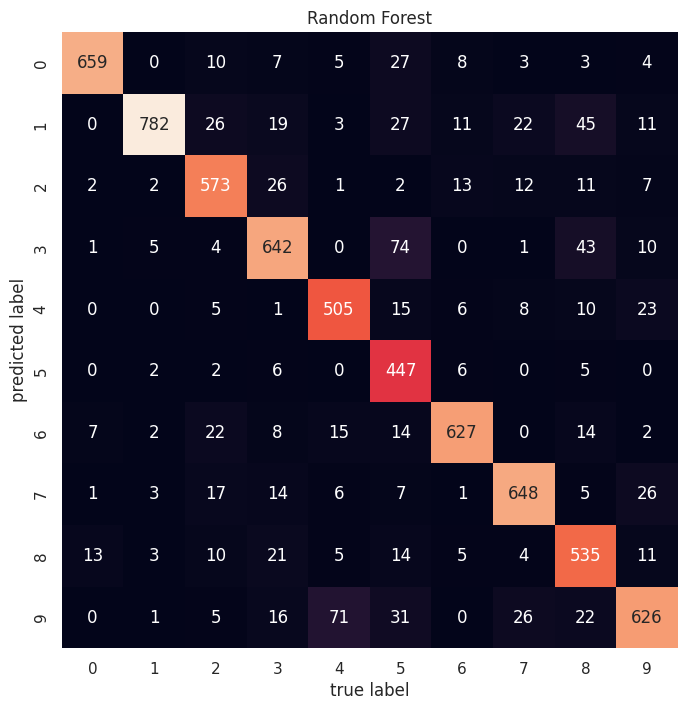

In [14]:

#print("Please implement me")
# Instantiate and evaluate the Random Forest model
learning_algo = RandomForestLearningAlgorithm(n_estimators = 100, criterion = 'gini', max_depth = 5, min_samples_split = 2)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       683
           1       0.96      0.98      0.97       800
           2       0.94      0.95      0.94       674
           3       0.93      0.92      0.92       760
           4       0.94      0.94      0.94       611
           5       0.96      0.93      0.95       658
           6       0.95      0.97      0.96       677
           7       0.95      0.94      0.94       724
           8       0.93      0.92      0.93       693
           9       0.91      0.92      0.92       720

    accuracy                           0.95      7000
   macro avg       0.95      0.95      0.95      7000
weighted avg       0.95      0.95      0.95      7000

CPU times: user 1min 29s, sys: 91.7 ms, total: 1min 29s
Wall time: 1min 31s


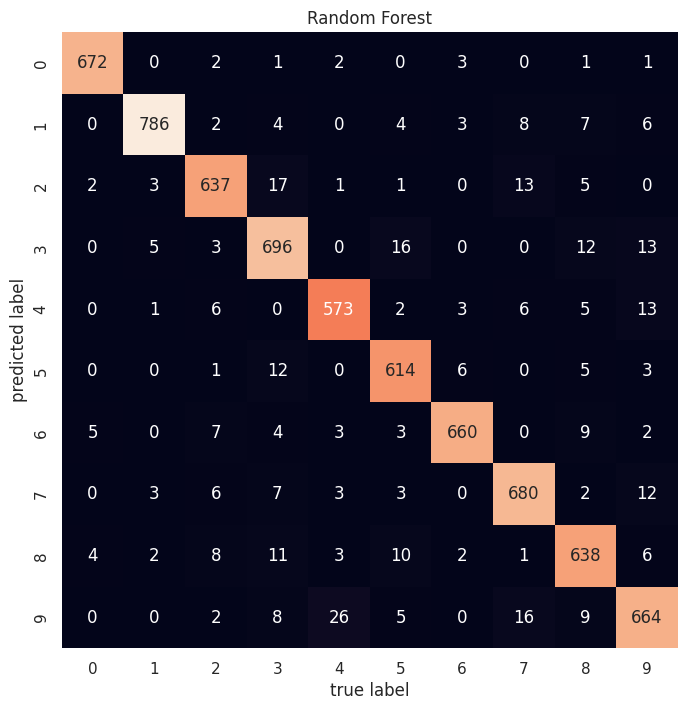

In [15]:
# Trying with more estimators (200) and a deeper tree (max_depth=10)
learning_algo = RandomForestLearningAlgorithm(n_estimators=200, criterion='entropy', max_depth=10, min_samples_split=5)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)


##Question 4.
What are the top three pairs of confusion (i.e., true row $i$, predicted column $j$), and are they the same as SVM? Why are these classes confused with each other?

**Answer**: The confusion matrix for the Radial Basis SVM with PCA reveals the top three digit pairs most frequently misclassified. The digit 2 is often mistaken for 3, with 19 misclassifications, likely due to their similar curved shapes when handwritten. Similarly, digits 2 and 8 are confused 21 times, as the loops in 8 can resemble a poorly written 2. Lastly, the digits 5 and 3 are misclassified 17 times, as their rounded shapes share common visual elements in some writing styles. Although PCA simplifies the feature space, it may also blur crucial distinctions needed to differentiate visually similar digits, highlighting the challenge of balancing dimensionality reduction with preserving necessary detail for accurate classification.

#4. Feedforward Neural Networks

In this section, we'll explore feedforward neural networks. First, we'll make some enhancements to a NN written using just numpy to give you a sense for how forward and back-propagation work, and how the weights are optimized using basic gradient descent.



##4.1 Neural network without libraries (Task 5)
Study the complete neural network implementation below. The architecture has an input width of 784 nodes, two hidden layers, and a softmax output layer of with 10 nodes (0-9).
Pay attention to the gradient calculation and the overall backpropagation algorithm, and how gradient descent adjusts the weights. Implement the ReLU activation funtion in the skeleton method provided below and compare the results to the sigmoid activation function.

Epoch: 1, Time Spent: 47.94s, Validation Accuracy: 31.63%
Epoch: 2, Time Spent: 100.45s, Validation Accuracy: 36.00%
Epoch: 3, Time Spent: 148.50s, Validation Accuracy: 37.59%
Epoch: 4, Time Spent: 196.50s, Validation Accuracy: 39.78%
Epoch: 5, Time Spent: 246.90s, Validation Accuracy: 42.49%
Epoch: 6, Time Spent: 296.62s, Validation Accuracy: 44.30%
Epoch: 7, Time Spent: 344.03s, Validation Accuracy: 45.33%
Epoch: 8, Time Spent: 394.03s, Validation Accuracy: 46.21%
Epoch: 9, Time Spent: 444.20s, Validation Accuracy: 47.06%
Epoch: 10, Time Spent: 491.83s, Validation Accuracy: 47.98%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.65      0.95      0.77       683
           1       0.53      0.98      0.69       800
           2       1.00      0.00      0.00       674
           3       0.48      0.85      0.61       760
           4       0.60      0.05      0.09       611
           5       0.00      0.00      0.00       658
           6       0.43      0.85      0.57       677
           7       0.38      0.90      0.53       724
           8       0.00      0.00      0.00       693
           9       0.59      0.05      0.09       720

    accuracy                           0.48      7000
   macro avg       0.46      0.46      0.34      7000
weighted avg       0.47      0.48      0.35      7000

CPU times: user 7min 38s, sys: 5min 59s, total: 13min 38s
Wall time: 8min 12s


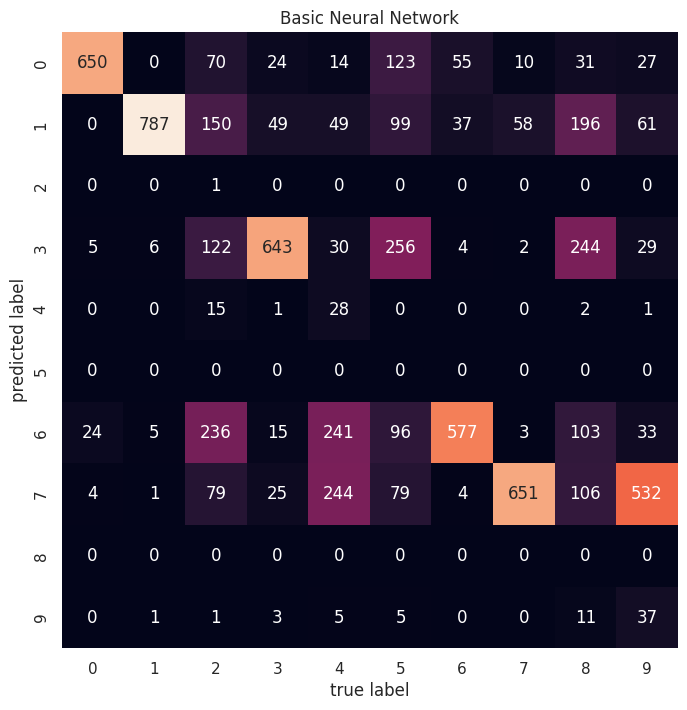

In [16]:
#@title Basic Neural Network Algorithm

class DeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # Save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    #def relu(self, x, derivative=False):
    #  raise NotImplementedError('Please implement ReLU!')

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Perfoms backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):

            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
      """Predicts on a test set."""
      return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def fit(self, x_train, y_train, x_val, y_val):
        y_train = to_categorical(y_train)
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):

                output = self.forward_pass(x)

                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
    @property
    def name(self) -> str:
      return 'Basic Neural Network'

learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001 )
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

For Relu


Epoch: 1, Time Spent: 46.01s, Validation Accuracy: 73.32%
Epoch: 2, Time Spent: 92.22s, Validation Accuracy: 83.83%
Epoch: 3, Time Spent: 142.89s, Validation Accuracy: 87.14%
Epoch: 4, Time Spent: 188.83s, Validation Accuracy: 88.90%
Epoch: 5, Time Spent: 234.09s, Validation Accuracy: 89.84%
Epoch: 6, Time Spent: 281.13s, Validation Accuracy: 90.51%
Epoch: 7, Time Spent: 327.82s, Validation Accuracy: 91.13%
Epoch: 8, Time Spent: 374.79s, Validation Accuracy: 91.59%
Epoch: 9, Time Spent: 422.11s, Validation Accuracy: 91.98%
Epoch: 10, Time Spent: 470.13s, Validation Accuracy: 92.25%
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       683
           1       0.94      0.98      0.96       800
           2       0.90      0.89      0.89       674
           3       0.91      0.88      0.89       760
           4       0.89      0.91      0.90       611
           5       0.87      0.90      0.89       658
           6       0.95      0.9

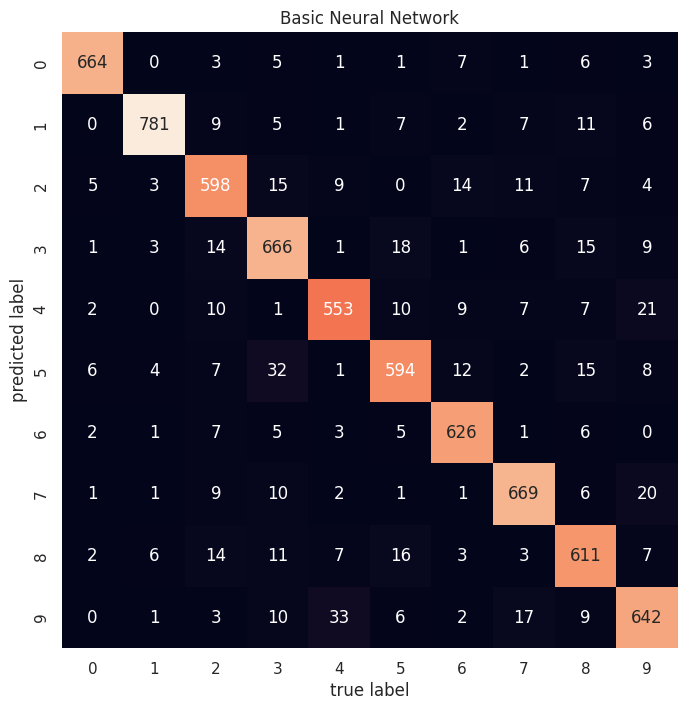

In [17]:
#@title Basic Neural Network Algorithm

class DeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # Save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    #def relu(self, x, derivative=False):
    #  raise NotImplementedError('Please implement ReLU!')

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.relu(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.relu(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Perfoms backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.relu(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.relu(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):

            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
      """Predicts on a test set."""
      return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def fit(self, x_train, y_train, x_val, y_val):
        y_train = to_categorical(y_train)
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):

                output = self.forward_pass(x)

                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
    @property
    def name(self) -> str:
      return 'Basic Neural Network'

learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001 )
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

##Question 5.
When executing multiple times (using ReLU or sigmoid activations) for a fixed number of iterations, how much does the validation accuracy vary at the end of the training? What is causing the variation in performance?

**Answer**:  In my case When I executed multiple runs of a neural network
validation accuracy changed a few percentage points i.e neural network using sigmoid activations chnaged from 53% to 57% and ReLu activations changed from 89% to 91%. This could happen because of the following reasons:
1. Random initialization of weights which can lead to different local minima during training, resulting in variations in the final model performance.
2. Different shuffling of the training data across runs can lead to variations in the learned features and model performance.
3. The variation may also differ based on the choice of the activation function; ReLU might yield more stable and higher performance due to its properties.

## Question 6.
Does the choice of activation function (ReLU vs. sigmoid) make any difference in validation accuracy?

**Answer**: Yes, the choice of activation function can significantly affect the validation accuracy of a neural network.
According to the output of the codes, it is evident that the ReLU activation function performs better than the sigmoid function in terms of validation accuracy.

##4.2 Feedforward Neural Network with Keras and Tensorflow (Task 6)
Next, set up and train a feedforward neural network in [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/).



1.   Paramaterize your model with the number of hidden layers, epochs, learning rate, and activation function.
2.   Add **early stopping** and add a patience parameter. You can apply the [keras callback function](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to implement early stopping.
3.   Apply sparse categorical entropy loss function.
4.   Apply Adaptive Moments (Adam) optimizer






In [18]:

class KerasDnnLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, hidden_layers, epochs=1000, learning_rate=0.001, activation='relu', patience=10):
        self.hidden_layers = hidden_layers
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.activation = activation
        self.model = self.build_model()
        self.early_stopping = keras.callbacks.EarlyStopping(
            patience=patience,
            monitor='val_loss',
            restore_best_weights=True
        )

    def build_model(self):
        model = keras.Sequential()
        model.add(layers.InputLayer(input_shape=(784,)))
        for units in self.hidden_layers:
            model.add(layers.Dense(units, activation=self.activation))
        model.add(layers.Dense(10, activation='softmax'))  # Output layer for 10 classes
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def fit(self, x_train, y_train, x_val, y_val):
        self.model.fit(x_train, y_train,
                       validation_data=(x_val, y_val),
                       epochs=self.epochs,
                       callbacks=[self.early_stopping],
                       batch_size=32,
                       verbose=1)

    def predict(self, X_test):
        return np.argmax(self.model.predict(X_test), axis=1)

    @property
    def name(self) -> str:
        return 'Keras Feedforward Neural Network'





Epoch 1/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8719 - loss: 0.4356 - val_accuracy: 0.9590 - val_loss: 0.1317
Epoch 2/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9670 - loss: 0.1132 - val_accuracy: 0.9735 - val_loss: 0.0864
Epoch 3/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9773 - loss: 0.0733 - val_accuracy: 0.9767 - val_loss: 0.0750
Epoch 4/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9831 - loss: 0.0550 - val_accuracy: 0.9760 - val_loss: 0.0762
Epoch 5/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9869 - loss: 0.0407 - val_accuracy: 0.9763 - val_loss: 0.0756
Epoch 6/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9903 - loss: 0.0313 - val_accuracy: 0.9757 - val_loss: 0.0825
Epoch 7/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9907 - loss: 0.0275 - val_accuracy: 0.9779 - val_loss: 0.0812
Epoch 8/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9

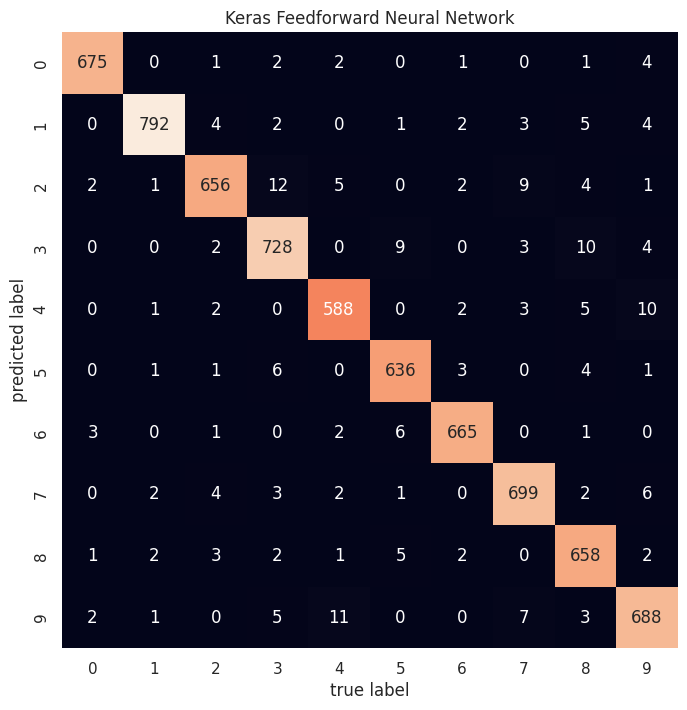

In [20]:
import numpy as np


# Ensure the data types are correct
y_train = np.asarray(y_train).astype(int)
y_val = np.asarray(y_val).astype(int)
y_test = np.asarray(y_test).astype(int)

x_train = np.asarray(x_train).astype(np.float32)
x_val = np.asarray(x_val).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)

# Define your train_eval function
def train_eval(learning_algo: BaseLearningAlgorithm, x_train, y_train, x_val, y_val, x_test, y_test):
    """Trains and evaluates the generic model."""
    learning_algo.fit(x_train, y_train, x_val, y_val)
    y_pred = learning_algo.predict(x_test)
    mat = confusion_matrix(y_test, y_pred)

    sns.set(rc={'figure.figsize': (8, 8)})
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['%d' % i for i in range(10)],
                yticklabels=['%d' % i for i in range(10)])
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title(learning_algo.name)

    print(classification_report(y_test, y_pred,
                                target_names=['%d' % i for i in range(10)]))

# Create and train the model
learning_algo = KerasDnnLearningAlgorithm(hidden_layers=[128, 64], epochs=1000, learning_rate=0.001, activation='relu')

# Train and evaluate the model
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)


##Question 6
Summarize the results of all your classifiers. Which classifiers performed better or worse than the logistic regression benchmark? Which method executed fastest in terms of time? Which was easiest to set up and parameterize? Which classes tended to get most often confused across all classifiers?

**Answer**:
Summary of Classifier Performance:
1. Logistic Regression:
Accuracy: 92%
F1-Score Range: 0.88 - 0.97
Execution Time: ~2 minutes (Wall time: 1min 21s)
Remarks: Served as the benchmark. High performance across all classes.

2. Basic SVM:
Accuracy: 93%
F1-Score Range: 0.90 - 0.98
Execution Time: ~10 minutes (Wall time: 10min 19s)
Remarks: Outperformed Logistic Regression slightly, but required significantly more time for training.

3. Radial Basis SVM with PCA:
Accuracy: 91%
F1-Score Range: 0.87 - 0.96
Execution Time: ~1.5 minutes (Wall time: 1min 33s)
Remarks: Performed slightly worse than basic SVM. The use of PCA sped up training but resulted in a slight drop in performance compared to Logistic Regression.

4. Random Forest with Gini:
Accuracy: 86%
F1-Score Range: 0.79 - 0.94
Execution Time: ~20 seconds (Wall time: 19.3s)
Remarks: Performed worse than Logistic Regression, especially for minority classes, but was the fastest method.

5. Random Forest with Entropy:
Accuracy: 95%
F1-Score Range: 0.92 - 0.98
Execution Time: ~1.5 minutes (Wall time: 1min 33s)
Remarks: Outperformed Logistic Regression and other classifiers. Achieved the highest accuracy among non-neural classifiers.

6. Basic Neural Network with Sigmoid Activation:
Accuracy: 57%
F1-Score Range: 0.00 - 0.73
Execution Time: ~13 minutes (Wall time: 8min 2s)
Remarks: The worst performer due to vanishing gradient issues and poor convergence. Failed to learn most classes accurately.

7. Basic Neural Network with ReLU Activation:
Accuracy: 91%
F1-Score Range: 0.88 - 0.94
Execution Time: ~13 minutes (Wall time: 8min 36s)
Remarks: Improved performance over sigmoid-based network, but training time was high. Matched Logistic Regression's accuracy.

8. Feedforward Neural Network (Keras + TensorFlow):
Accuracy: 97%
F1-Score Range: 0.96 - 0.99
Execution Time: ~2 minutes (Wall time: 2min 8s)
Remarks: Best performer overall with the highest accuracy and F1-scores for all classes. Executed faster than custom neural networks.

Key Insights:
1. Best Classifier:
Feedforward Neural Network achieved the best overall performance with 97% accuracy, significantly higher than Logistic Regression.
Worse Performers:

Basic Neural Network with Sigmoid Activation had the worst performance at 57% accuracy, far below Logistic Regression.

2. Execution Time:
Random Forest with Gini was the fastest, taking only ~19 seconds.
SVM classifiers were the slowest, especially Basic SVM, taking ~10 minutes.
Ease of Setup:

Logistic Regression and Random Forest were the easiest to set up and parameterize.
The neural network models, especially custom implementations, required more effort and tuning.
Common Class Confusions:

Classes 2, 3, and 8 were commonly misclassified across most classifiers. These classes had lower F1-scores and recall values, indicating that they shared overlapping features and were harder to distinguish.

#Optional Extra Credit (max course credit: 3%)


*   Implement early stopping in 4.1 (**1% extra credit**).
*   Add in one or more Keras dropout layers in 4.2 (**1% extra credit**).
*   Implement mini-batch gradient descent in 4.1, replacing stochastic gradient descent. Instead of making an update to a parameter for each sample, make an update based on the averaged value of each sample in a mini-batch. The size of the mini-batch is usually below 64. (**3% extra credit**)
*  Initialize biases and add them to Z in 4.1 before the activation function in the forward pass, and update the biases in the backward pass.  (**2% extra credit**)




**Implement early stopping in 4.1 **

In [21]:
class DeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001, patience=5):
        """
        Initializes the deep neural network learning algorithm.

        Parameters:
        sizes (list): List containing the number of nodes in each layer.
        epochs (int): Number of training epochs.
        l_rate (float): Learning rate for weight updates.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        """
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.patience = patience  # Number of epochs with no improvement before stopping

        # Save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        """
        Applies the sigmoid activation function.

        Parameters:
        x (np.array): Input array.
        derivative (bool): If True, returns the derivative of the sigmoid function.

        Returns:
        np.array: Activated output or derivative.
        """
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def relu(self, x, derivative=False):
        """
        Applies the ReLU activation function.

        Parameters:
        x (np.array): Input array.
        derivative (bool): If True, returns the derivative of the ReLU function.

        Returns:
        np.array: Activated output or derivative.
        """
        if derivative:
            return np.where(x > 0, 1, 0)
        return np.maximum(0, x)

    def softmax(self, x, derivative=False):
        """
        Applies the softmax function for multi-class classification.

        Parameters:
        x (np.array): Input array.
        derivative (bool): If True, returns the derivative of the softmax function.

        Returns:
        np.array: Softmax output or derivative.
        """
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        """
        Initializes the weights of the neural network layers.

        Returns:
        dict: Dictionary containing weights for each layer.
        """
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        """
        Performs a forward pass through the network.

        Parameters:
        x_train (np.array): Input data.

        Returns:
        np.array: Output from the final layer of the network.
        """
        params = self.params

        # Input layer activations becomes sample
        params['A0'] = x_train

        # Input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # Hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # Hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """
        Performs backpropagation to compute weight updates.

        Parameters:
        y_train (np.array): True labels (one-hot encoded).
        output (np.array): Network's output.

        Returns:
        Dict[str, np.array]: Weight changes for each layer.
        """
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """
        Updates the network parameters using the computed gradients.

        Parameters:
        changes_to_w (Dict[str, np.array]): Changes to be applied to the weights.
        """
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
        Computes the accuracy of the model on the validation set.

        Parameters:
        x_val (np.array): Validation input data.
        y_val (np.array): Validation true labels.

        Returns:
        float: Accuracy of the model on the validation data.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array:
        """
        Predicts the class labels for the test set.

        Parameters:
        X_test (np.array): Test input data.

        Returns:
        np.array: Predicted class labels.
        """
        return np.array([np.argmax(self.forward_pass(x)) for x in X_test])

    def fit(self, x_train, y_train, x_val, y_val):
        """
        Trains the model on the training data and validates on the validation set.

        Parameters:
        x_train (np.array): Training input data.
        y_train (np.array): Training true labels.
        x_val (np.array): Validation input data.
        y_val (np.array): Validation true labels.
        """
        y_train = to_categorical(y_train)  # Convert labels to one-hot encoding
        start_time = time.time()
        best_accuracy = 0  # Best validation accuracy observed
        epochs_no_improvement = 0  # Counter for epochs with no improvement

        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            # Compute validation accuracy after each epoch
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration + 1, time.time() - start_time, accuracy * 100
            ))

            # Early stopping check
            if accuracy > best_accuracy:
                best_accuracy = accuracy  # Update best accuracy
                epochs_no_improvement = 0  # Reset the no improvement counter
            else:
                epochs_no_improvement += 1

            # Stop training if no improvement exceeds patience threshold
            if epochs_no_improvement >= self.patience:
                print("Early stopping triggered after {} epochs without improvement.".format(self.patience))
                break

    @property
    def name(self) -> str:
        return 'Basic Neural Network'


Epoch: 1, Time Spent: 49.88s, Validation Accuracy: 21.70%
Epoch: 2, Time Spent: 98.13s, Validation Accuracy: 29.27%
Epoch: 3, Time Spent: 149.46s, Validation Accuracy: 31.17%
Epoch: 4, Time Spent: 198.47s, Validation Accuracy: 32.57%
Epoch: 5, Time Spent: 245.97s, Validation Accuracy: 34.22%
Epoch: 6, Time Spent: 293.31s, Validation Accuracy: 36.79%
Epoch: 7, Time Spent: 345.73s, Validation Accuracy: 39.33%
Epoch: 8, Time Spent: 393.21s, Validation Accuracy: 41.59%
Epoch: 9, Time Spent: 443.78s, Validation Accuracy: 44.40%
Epoch: 10, Time Spent: 493.66s, Validation Accuracy: 47.38%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.51      0.98      0.67       683
           1       0.44      0.99      0.61       800
           2       0.45      0.66      0.54       674
           3       0.63      0.66      0.65       760
           4       0.66      0.23      0.34       611
           5       0.00      0.00      0.00       658
           6       0.97      0.09      0.16       677
           7       0.35      0.88      0.51       724
           8       1.00      0.01      0.02       693
           9       0.31      0.01      0.01       720

    accuracy                           0.47      7000
   macro avg       0.53      0.45      0.35      7000
weighted avg       0.53      0.47      0.36      7000

CPU times: user 7min 36s, sys: 6min 2s, total: 13min 38s
Wall time: 8min 14s


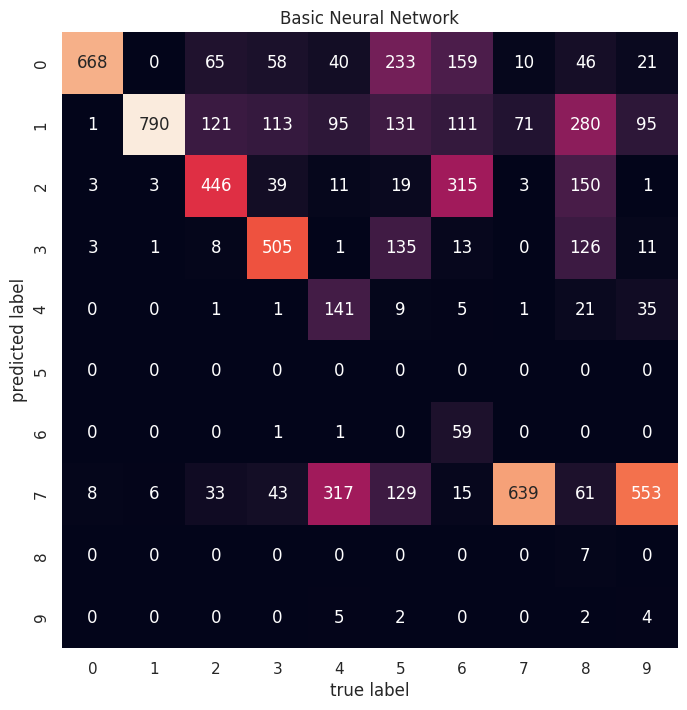

In [22]:
learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001, patience=5)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)


**Add in one or more Keras dropout layers in 4.2 **


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7038 - loss: 0.9116 - val_accuracy: 0.9432 - val_loss: 0.1893
Epoch 2/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9046 - loss: 0.3340 - val_accuracy: 0.9537 - val_loss: 0.1530
Epoch 3/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9231 - loss: 0.2752 - val_accuracy: 0.9613 - val_loss: 0.1274
Epoch 4/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9339 - loss: 0.2369 - val_accuracy: 0.9640 - val_loss: 0.1212
Epoch 5/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9377 - loss: 0.2177 - val_accuracy: 0.9678 - val_loss: 0.1070
Epoch 6/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9396 - loss: 0.2144 - val_accuracy: 0.9679 - val_loss: 0.1052
Epoch 7/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9471 - loss: 0.1946 - val_accuracy: 0.9705 - val_loss: 0.0958
Epoch 8/1000
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9467

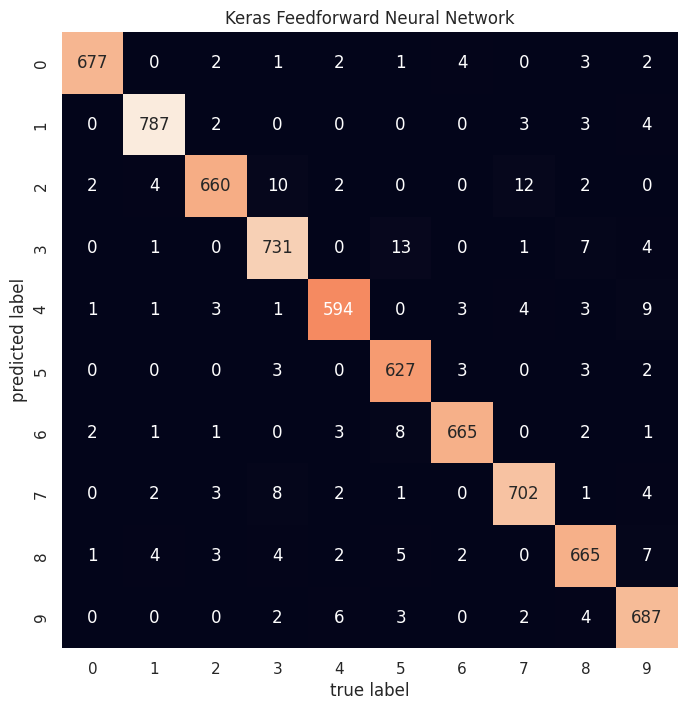

In [26]:

class KerasDnnLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, hidden_layers, epochs=1000, learning_rate=0.001, activation='relu', patience=10, dropout_rate=0.5):
        """
        Initializes the Keras Deep Neural Network algorithm.

        Parameters:
        - hidden_layers: List containing the number of units for each hidden layer.
        - epochs: Number of training epochs.
        - learning_rate: Learning rate for the optimizer.
        - activation: Activation function to use for the hidden layers.
        - patience: Number of epochs with no improvement after which training will be stopped.
        - dropout_rate: Fraction of input units to drop; used to prevent overfitting.
        """
        self.hidden_layers = hidden_layers
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.activation = activation
        self.dropout_rate = dropout_rate  # Set the dropout rate
        self.model = self.build_model()  # Build the neural network model
        self.early_stopping = keras.callbacks.EarlyStopping(
            patience=patience,  # Early stopping callback
            monitor='val_loss',  # Monitor validation loss
            restore_best_weights=True  # Restore best weights after early stopping
        )

    def build_model(self):
        """Builds the Keras Sequential model."""
        model = keras.Sequential()
        model.add(layers.InputLayer(input_shape=(784,)))  # Input layer for 784 features (e.g., flattened 28x28 images)

        # Adding hidden layers with dropout
        for units in self.hidden_layers:
            model.add(layers.Dense(units, activation=self.activation))  # Add dense layer with specified activation
            model.add(layers.Dropout(self.dropout_rate))  # Add dropout layer to prevent overfitting

        model.add(layers.Dense(10, activation='softmax'))  # Output layer for 10 classes (softmax for multi-class classification)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),  # Adam optimizer
                      loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
                      metrics=['accuracy'])  # Metrics to track during training
        return model

    def fit(self, x_train, y_train, x_val, y_val):
        """Fits the model to the training data."""
        self.model.fit(x_train, y_train,
                       validation_data=(x_val, y_val),  # Validation data for monitoring
                       epochs=self.epochs,  # Number of epochs
                       callbacks=[self.early_stopping],  # Early stopping callback
                       batch_size=32,  # Batch size for training
                       verbose=1)  # Verbosity mode

    def predict(self, X_test):
        """Predicts classes for the test set."""
        return np.argmax(self.model.predict(X_test), axis=1)  # Return class with highest probability

    @property
    def name(self) -> str:
        """Returns the name of the learning algorithm."""
        return 'Keras Feedforward Neural Network'


# Create an instance of the KerasDnnLearningAlgorithm with desired parameters
learning_algo = KerasDnnLearningAlgorithm(hidden_layers=[128, 64], epochs=1000, learning_rate=0.001, activation='relu', dropout_rate=0.5)

# Train and evaluate the model using the train_eval function
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)
